In [1]:
import logging
from agent_config import Config
from models import create_llm 
from langchain_core.messages import ToolMessage 
from typing import Any, Annotated 
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,  END 
from langchain.tools import tool
from langchain_core.messages import ToolMessage
from langchain_core.messages.tool import ToolCall
import http.client
import json
from typing import List, Dict, Type
from pydantic import BaseModel, Field
from langchain_core.tools import BaseTool

# Setup logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)  # or INFO

# Create console handler and set level
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)

# Create formatter and add it to the handler
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)

# Add the handler to the logger
logger.addHandler(ch)

llm = create_llm(Config.MODEL) 

logger.info(f"Model loaded: {Config.MODEL}")

response = llm.invoke("HI")

logger.info(f"LLM invoked with input 'HI', response: {response}")


2025-07-16 01:01:24,147 - INFO - Model loaded: ModelConfig(name='devstral:24b', temperature=0.01, provider=<ModelProvider.OLLAMA: 'ollama'>)
2025-07-16 01:01:26,797 - INFO - LLM invoked with input 'HI', response: content='Hello! How can I assist you today?' additional_kwargs={} response_metadata={'model': 'devstral:24b', 'created_at': '2025-07-15T21:01:27.138134212Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2565410275, 'load_duration': 30613134, 'prompt_eval_count': 1226, 'prompt_eval_duration': 1780475604, 'eval_count': 10, 'eval_duration': 749252632, 'model_name': 'devstral:24b'} id='run--0b56b0a9-dda1-4a8e-95e7-04959399d05e-0' usage_metadata={'input_tokens': 1226, 'output_tokens': 10, 'total_tokens': 1236}


In [2]:
from  agent import ChatAgentGraph
from tools import InternetSearchTool

serach_tool=InternetSearchTool()
tools = [serach_tool]
chat_agent = ChatAgentGraph(llm=llm, tools=tools)

In [3]:
# import http.client
# import json

# conn = http.client.HTTPSConnection("google.serper.dev")
# payload = json.dumps({
#   "q": "nvidia stock "
# })
# headers = {
#   'X-API-KEY': '79ed7737508eaf88b020d39e133f17ed69b829b8',
#   'Content-Type': 'application/json'
# }
# conn.request("POST", "/search", payload, headers)
# res = conn.getresponse()
# data = res.read()
# print(data.decode("utf-8"))

In [4]:
 
class InternetSearchInput(BaseModel):
    query: str = Field(..., description="Search query to send to Google via Serper API")

class InternetSearchTool(BaseTool):
    name: str = "internet_search_tool"
    description: str = "Search the internet using Google and return organic search results only"
    args_schema: Type[BaseModel] = InternetSearchInput

    def _run(self, query: str) -> List[Dict[str, str]]:
        logger.info(f"Starting internet search for query: {query}")
        try:
            conn = http.client.HTTPSConnection("google.serper.dev")
            payload = json.dumps({"q": query})
            headers = {
                'X-API-KEY': Config.SERPER_API_TOKEN,  # Replace with your actual API key
                'Content-Type': 'application/json'
            }

            conn.request("POST", "/search", payload, headers)
            res = conn.getresponse()
            data = res.read().decode("utf-8")
            json_data = json.loads(data)
            logger.debug(f"Raw response data: {json_data}")

            organic_results = json_data.get("organic", [])
            results = []
            for result in organic_results:
                res_item = {
                    # "title": result.get("title"),
                    "link": result.get("link"),
                    "snippet": result.get("snippet")
                }
                results.append(res_item)
                logger.debug(f"Parsed search result item: {res_item}")

            logger.info(f"Search completed, found {len(results)} organic results")
            return results

        except Exception as e:
            logger.error(f"Error during internet search: {e}", exc_info=True)
            return [{"error": str(e)}]

    def _arun(self, *args, **kwargs):
        raise NotImplementedError("Async not supported for this tool.")

serach_tool = InternetSearchTool()
           

# search_result=serach_tool.invoke({"query":"nvidia stock "})
# content=json.dumps(search_result,indent=2)
# content

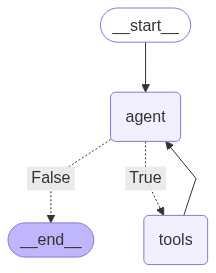

In [5]:


class State(TypedDict):
    messages: Annotated[list, add_messages]
    hybrid_search: bool


def get_available_tools() -> List[BaseTool]:
    return [serach_tool]


def call_tool(tool_call: ToolCall) -> Any:
    tools_by_name = {tool.name: tool for tool in get_available_tools()}
    tool = tools_by_name[tool_call["name"]]
    response = tool.invoke(tool_call["args"])
    return ToolMessage(content=json.dumps(response, indent=2), tool_call_id=tool_call["id"])


llm_with_tools = llm.bind_tools(get_available_tools())

tools = [serach_tool]

# Graph builder
graph_builder = StateGraph(State)


def tool_node(state: State):
    if not state.get("hybrid_search", True):
        logger.info("[ToolNode] Tool execution skipped due to hybrid_search=False")
        return state

    messages = state['messages']
    last_message = messages[-1]

    tool_messages = []
    logger.debug("************ IN TOOL NODE ************")

    for tool_call in last_message.tool_calls:
        try:
            tool_msg = call_tool(tool_call)
            tool_messages.append(tool_msg)
            # logger.info(f"[ToolNode] Tool executed: {tool_call['name']} → {tool_msg.content}")
        except Exception as e:
            logger.error(f"[ToolNode] Tool call failed: {tool_call['name']} | Error: {e}", exc_info=True)
            continue

    state['messages'] = messages + tool_messages
    return state


def chatbot(state: State):
    messages = state["messages"]
    if state.get("hybrid_search", True):
        # Tool-enabled LLM
        new_msg = llm_with_tools.invoke(messages)
        logger.debug("[Chatbot] Invoked LLM with tools")
    else:
        # Tool-less LLM — prevents emitting <tool_call>
        new_msg = llm.invoke(messages)
        logger.debug("[Chatbot] Invoked LLM without tools")
    return {"messages": messages + [new_msg]}


def tool_exists(state: State):
    if not state.get("hybrid_search", True):
        return False
    result = state['messages'][-1]
    exists = hasattr(result, "tool_calls") and len(result.tool_calls) > 0
    logger.debug(f"[Tool Exists] Tool calls present: {exists}")
    return exists


graph_builder.add_node("agent", chatbot)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges("agent", tools_condition)
graph_builder.add_conditional_edges(
    "agent",
    tool_exists,
    {True: "tools", False: END}
)
graph_builder.add_edge("tools", "agent")
graph_builder.set_entry_point("agent")
graph_builder.set_finish_point("agent")

graph = graph_builder.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [6]:
import datetime
from langchain_core.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage, AIMessage, trim_messages
from langchain_core.runnables.config import RunnableConfig
import uuid
myuuid = uuid.uuid4()

 
SYSTEM_PROMPT = '''
You are an intelligent assistant capable of answering a wide range of questions using your internal knowledge.

You also have access to a tool called `internet_search_tool` that allows you to perform real-time web searches to get up-to-date information.

---

## 🎯 Decision Strategy:

You must decide whether to answer directly or to trigger the `internet_search_tool`.

### ✅ Use your own knowledge if:
- The question is general, timeless, or clearly answerable from your internal knowledge.
- The topic is about facts, science, definitions, instructions, or logic that hasn’t changed recently.

### 🔎 Use `internet_search_tool` if:
- The user asks for **recent**, **breaking**, or **currently happening** events (e.g., "today", "now", "latest", "current").
- The topic involves **live data** (e.g., stock prices, weather, news, sports results, product availability).
- You are unsure or not confident in your answer.

---

## 🧠 Reasoning and Tool Usage

If you decide to call a tool, always explain why you're doing so using a `reasoning` field.

When you use `internet_search_tool`, always include a **Sources** section in your final response listing the URLs or references returned by the tool.

Include the search results summary and the sources in a clear, well-formatted manner.

---

## 🧾 Output Format

- Always answer in Markdown.
- If answering directly, just reply with the answer.
- If using a tool, respond with:
  - Your explanation and reasoning in Markdown,
  - The summarized search results,
  - A **Sources** section formatted exactly as a JSON list of URLs inside square brackets `[]`.

- Example:

The CEO of Avrioc Technologies is Berlin Corleone.

Sources
["https://avrioc.com/about-us/", "https://www.crunchbase.com/person/berlin-corleone", "https://www.dnb.com/business-directory/company-profiles.avrioc_technologies_llc.ac65523ee63f182e614fc6acbfa54138.html"]


- **Important:** Do **not** output sources as bullet points or free text. Always output them as a JSON-style list inside square brackets.
- Your entire response should be a single Markdown-formatted message containing your answer and the properly formatted Sources list.

---

Your goal is to provide clear, accurate, and helpful answers — either from memory or the internet.
'''.strip()


system_message = SystemMessage(
    content=SYSTEM_PROMPT
)

input = "who is the CEO of Avrioc Technologies"
messages = [system_message, HumanMessage(content=input)]
config = {
    "configurable": {
        "thread_id": myuuid
    },
    "recursion_limit": Config.Agent.MAX_ITERATIONS
}

# hybrid_search = False disables tool execution
# result = chat_agent.invoke({
#     "messages": messages,
#     "hybrid_search": True
# }, config=config)


In [7]:
# print(result['messages'][-1].content)

In [8]:
# result['message']

In [9]:
for message_chunk, metadata in graph.stream( 
   {
    "messages": messages,
    "hybrid_search": True
},
    stream_mode="messages", config=config
):
    if message_chunk.content:
        print(message_chunk.content, end="", flush=True)

2025-07-16 01:01:29,987 - DEBUG - [Chatbot] Invoked LLM with tools
2025-07-16 01:01:29,989 - DEBUG - [Tool Exists] Tool calls present: True
2025-07-16 01:01:29,992 - DEBUG - ************ IN TOOL NODE ************
2025-07-16 01:01:29,994 - INFO - Starting internet search for query: CEO of Avrioc Technologies
2025-07-16 01:01:31,254 - DEBUG - Raw response data: {'searchParameters': {'q': 'CEO of Avrioc Technologies', 'type': 'search', 'engine': 'google'}, 'organic': [{'title': 'Avrioc Technologies - Profiles & Contacts', 'link': 'https://www.crunchbase.com/organization/avrioc-technologies/people', 'snippet': 'Avrioc Technologies has 1 current employee profile, Founder and CEO Berlin Corleone .', 'position': 1}, {'title': 'Powered by AI - Avrioc Technologies', 'link': 'https://avrioc.com/about-us/', 'snippet': 'We are dedicated to positioning the UAE at the forefront of worldwide innovation. Akhtar Saeed Hashmi. Chief Executive Officer.', 'position': 2}, {'title': 'Berlin Corleone - Found

[
  {
    "link": "https://www.crunchbase.com/organization/avrioc-technologies/people",
    "snippet": "Avrioc Technologies has 1 current employee profile, Founder and CEO Berlin Corleone ."
  },
  {
    "link": "https://avrioc.com/about-us/",
    "snippet": "We are dedicated to positioning the UAE at the forefront of worldwide innovation. Akhtar Saeed Hashmi. Chief Executive Officer."
  },
  {
    "link": "https://www.crunchbase.com/person/berlin-corleone",
    "snippet": "Berlin Corleone has 2 current jobs as Founder and Chief Executive Officer at sabeFUEL and Founder and CEO at Avrioc Technologies."
  },
  {
    "link": "https://www.dnb.com/business-directory/company-profiles.avrioc_technologies_llc.ac65523ee63f182e614fc6acbfa54138.html",
    "snippet": "AVRIOC TECHNOLOGIES LLC \u00b7 Akhtar Saeed Hashmi. Chief Executive Officer \u00b7 Contact 2 \u00b7 Contact 3."
  },
  {
    "link": "https://ae.linkedin.com/company/avrioctech",
    "snippet": "Avrioc Technologies, based in Abu Dha

2025-07-16 01:01:39,270 - DEBUG - [Chatbot] Invoked LLM with tools
2025-07-16 01:01:39,273 - DEBUG - [Tool Exists] Tool calls present: False
